In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

c:\Users\Amirreza\.conda\envs\deeplearning\Lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


Using device: cuda


In [3]:
# Define the classes of interest
classes = ['airplane','automobile']

# Define the transformations to apply to the data

normalize = transforms.Normalize(
    mean=[0.4914, 0.4822, 0.4465],
    std=[0.2023, 0.1994, 0.2010],
)

transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    normalize,
])

# Load the CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

transform = transforms.Compose([
    transforms.Resize((227,227)),
    transforms.ToTensor(),
    normalize,
])

test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

# Filter the dataset to include only the specified classes
train_indices = [idx for idx, label in enumerate(train_dataset.targets) if label in [0, 1]]
test_indices = [idx for idx, label in enumerate(test_dataset.targets) if label in [0, 1]]


#edit validationset hyper params
random_seed = 1
valid_size=0.1
num_train = len(train_indices)
split = int(np.floor(valid_size * num_train))
np.random.seed(random_seed)
np.random.shuffle(train_indices)

train_idx, valid_idx = train_indices[split:], train_indices[:split]

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Create the train and test data loaders
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=train_sampler
)

valid_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, sampler=valid_sampler
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, sampler=test_sampler
)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 227, 227])


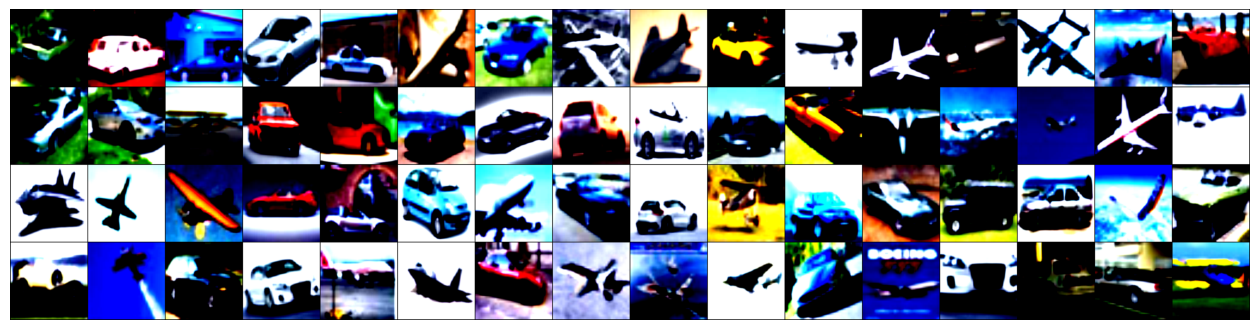

In [4]:
for i, (images, labels) in enumerate(train_loader):
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [5]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Instantiate the model
model = AlexNet()

In [6]:
num_classes = 2
num_epochs = 20
batch_size = 64
learning_rate = 0.01

model = AlexNet(num_classes).to(device)


# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)


# Train the model
total_step = len(train_loader)

In [28]:
total_step = len(train_loader)
best_loss = float('inf')  # Initialize the best loss with infinity

losses = []
accuracies = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())

    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
          .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        accuracy = 100 * correct / total
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, accuracy))
        accuracies.append(accuracy)
        # Save the best parameters based on the lowest validation loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), 'best_model.pth')


Epoch [1/20], Step [141/141], Loss: 0.5310
Accuracy of the network on the 5000 validation images: 73.0 %
Epoch [2/20], Step [141/141], Loss: 0.3673
Accuracy of the network on the 5000 validation images: 86.3 %
Epoch [3/20], Step [141/141], Loss: 0.1407
Accuracy of the network on the 5000 validation images: 89.9 %
Epoch [4/20], Step [141/141], Loss: 0.1674
Accuracy of the network on the 5000 validation images: 92.7 %
Epoch [5/20], Step [141/141], Loss: 0.1028
Accuracy of the network on the 5000 validation images: 93.9 %
Epoch [6/20], Step [141/141], Loss: 0.3328
Accuracy of the network on the 5000 validation images: 93.4 %
Epoch [7/20], Step [141/141], Loss: 0.2778
Accuracy of the network on the 5000 validation images: 93.0 %
Epoch [8/20], Step [141/141], Loss: 0.0385
Accuracy of the network on the 5000 validation images: 95.2 %
Epoch [9/20], Step [141/141], Loss: 0.0824
Accuracy of the network on the 5000 validation images: 93.1 %
Epoch [10/20], Step [141/141], Loss: 0.0848
Accuracy of

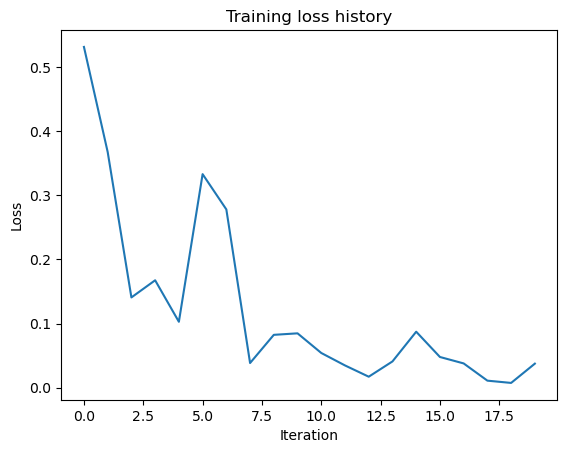

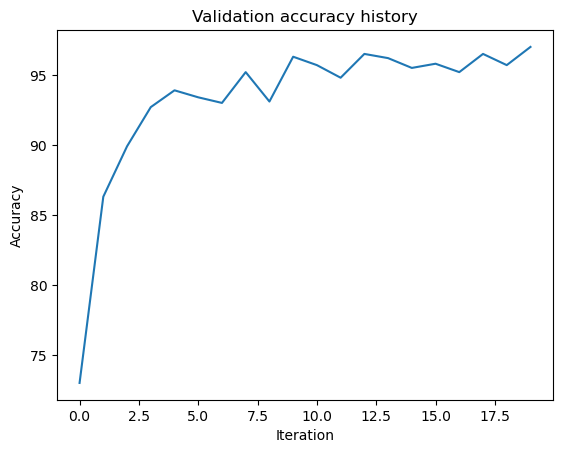

In [37]:
# Plot the training losses
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# Plot the validation accuracy
plt.plot(accuracies)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Validation accuracy history')
plt.show()

In [9]:
# Load the best parameters
model.load_state_dict(torch.load('best_model.pth'))

# Calculate the test loss
with torch.no_grad():
    test_correct = 0
    test_total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        del images, labels, outputs

    test_accuracy = 100 * test_correct / test_total
    print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), test_accuracy))

Accuracy of the network on the 10000 test images: 97.0 %


In [8]:
from torch.utils.data import Dataset, DataLoader , Subset ,random_split

class Cifar_Ten(Dataset):
    def __init__(self, train,transform=None):
        self.is_train = train
        if self.is_train:
            normalize = transforms.Normalize(
                mean=[0.4914, 0.4822, 0.4465],
                std=[0.2023, 0.1994, 0.2010],
            )
        else :
            normalize = transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            )

        self.transform = transforms.Compose([
            transforms.Resize((227,227)),
            transforms.ToTensor(),
            normalize,
        ])

        self.data = datasets.CIFAR10(
            root='./data',
            train=self.is_train,
            download=True,
            transform=self.transform
        )

        # Filter automobile and plane
        self.dataset_indices = [i for i in range(len(self.data.targets)) if self.data.targets[i] in [0, 1]]
        self.dataset = Subset(self.data, self.dataset_indices)

    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, item):
        try:   
            anchor, anchor_label = self.dataset[item]
            labels = torch.tensor(self.data.targets)[self.dataset_indices]

            # Select a positive sample
            positive_indices = torch.nonzero(labels == anchor_label).squeeze()
            positive_index = np.random.choice(positive_indices.numpy())
            positive_img, _ = self.dataset[positive_index]

            # Select a negative sample
            negative_indices = torch.nonzero(labels != anchor_label).squeeze()
            negative_index = np.random.choice(negative_indices.numpy())
            negative_img, _ = self.dataset[negative_index]

            return anchor, positive_img, negative_img, anchor_label
        except Exception as e:
            print(e)
            return None

In [10]:
ds = Cifar_Ten(True)
test_ds = Cifar_Ten(False)

# Assuming `dataset` is your full dataset
train_size = int(0.8 * len(ds))  # 80% for training
valid_size = len(ds) - train_size  # 20% for validation

train_ds, valid_ds = random_split(ds, [train_size, valid_size])

triplet_train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
triplet_valid_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)
triplet_test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [11]:
# Check the dataset sizes
print(f"Number of training examples: {len(train_ds)}")
print(f"Number of test examples: {len(test_ds)}")

Number of training examples: 8000
Number of test examples: 2000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


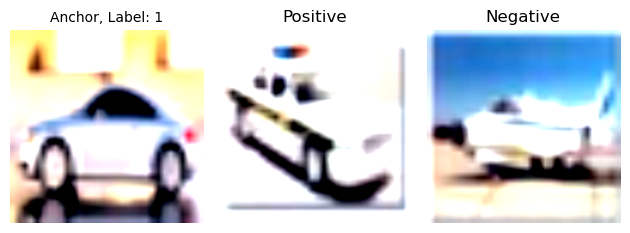

In [48]:
for (anchor, positive, negative, label) in triplet_train_loader:
    # Unnormalize the images
    anchor = anchor / 2 + 0.5
    positive = positive / 2 + 0.5
    negative = negative / 2 + 0.5

    # Plot Anchor
    plt.subplot(1, 3, 1)
    npimg_anchor = anchor.numpy()[0, :]
    plt.imshow(np.transpose(npimg_anchor, (1, 2, 0)))
    plt.title(f'Anchor, Label: {label[0]}', fontsize=10)
    plt.axis('off')

    # Plot Positive
    plt.subplot(1, 3, 2)
    npimg_positive = positive.numpy()[0, :]
    plt.imshow(np.transpose(npimg_positive, (1, 2, 0)))
    plt.title('Positive')
    plt.axis('off')


    # Plot Negative
    plt.subplot(1, 3, 3)
    npimg_negative = negative.numpy()[0, :]
    plt.imshow(np.transpose(npimg_negative, (1, 2, 0)))
    plt.title('Negative')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    break  # Break after the first batch

In [49]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin
    
    def forward(self, anchor: torch.Tensor, positive: torch.Tensor, negative: torch.Tensor) -> torch.Tensor:
        distance_positive = torch.dist(anchor, positive)
        distance_negative = torch.dist(anchor, negative)
        losses = torch.relu(distance_positive - distance_negative + self.margin)

        return losses.mean()

In [50]:
# Instantiate the new model
new_model = AlexNet(num_classes).to(device)

# Load the weights from the saved model
model.load_state_dict(torch.load('best_model.pth'))

# Initialize the weights of the new model from the loaded model
new_model.load_state_dict(model.state_dict())

# Freeze the weights of the last layer
for param in new_model.classifier[-1].parameters():
    param.requires_grad = False

In [51]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)
criterion = nn.TripletMarginLoss()

In [54]:
epochs = 10
losses = []
accuracies = []

best_loss = float('inf')  # Initialize the best loss with infinity

best_loss = float('inf')

for epoch in range(epochs):
    for i, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(triplet_train_loader):
        # Move tensors to the configured device
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        
        # Forward pass
        anchor_output = new_model(anchor_img)
        positive_output = new_model(positive_img)
        negative_output = new_model(negative_img)
        loss = criterion(anchor_output, positive_output, negative_output)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(loss.item())

    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
            .format(epoch+1, epochs, i+1, len(triplet_train_loader), loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (image,_,_,label) in enumerate(triplet_valid_loader):
            image = image.to(device)
            label = label.to(device)
            outputs = new_model(image)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            del image, label, outputs

        accuracy = 100 * correct / total
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, accuracy))
        accuracies.append(accuracy)
        # Save the best parameters based on the lowest validation loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), 'best_triplet_model.pth')
                  

Epoch [1/10], Step [125/125], Loss: 0.0205
Accuracy of the network on the 5000 validation images: 98.55 %
Epoch [2/10], Step [125/125], Loss: 0.0640
Accuracy of the network on the 5000 validation images: 98.55 %
Epoch [3/10], Step [125/125], Loss: 0.1116
Accuracy of the network on the 5000 validation images: 98.35 %
Epoch [4/10], Step [125/125], Loss: 0.2183
Accuracy of the network on the 5000 validation images: 98.85 %
Epoch [5/10], Step [125/125], Loss: 0.1446
Accuracy of the network on the 5000 validation images: 98.7 %
Epoch [6/10], Step [125/125], Loss: 0.1357
Accuracy of the network on the 5000 validation images: 98.5 %
Epoch [7/10], Step [125/125], Loss: 0.1540
Accuracy of the network on the 5000 validation images: 98.7 %
Epoch [8/10], Step [125/125], Loss: 0.1314
Accuracy of the network on the 5000 validation images: 98.5 %
Epoch [9/10], Step [125/125], Loss: 0.1436
Accuracy of the network on the 5000 validation images: 98.65 %
Epoch [10/10], Step [125/125], Loss: 0.2445
Accura

``The zero loss`` was an accident. The model was trained on the training data and the validation data was used to evaluate the model. The validation data was not used to train the model.

The zero loss of the model is not a good indicator of the model performance. The model is overfitting the training data.

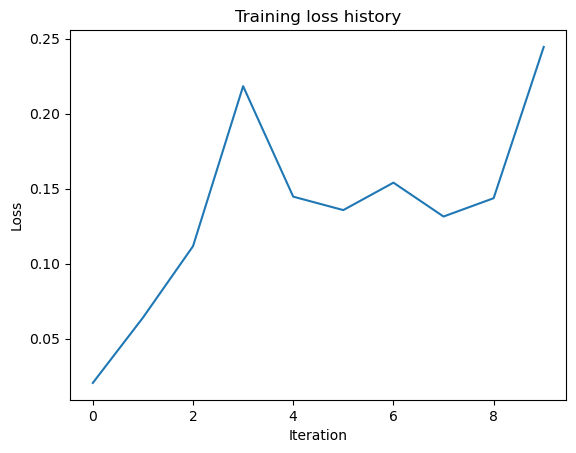

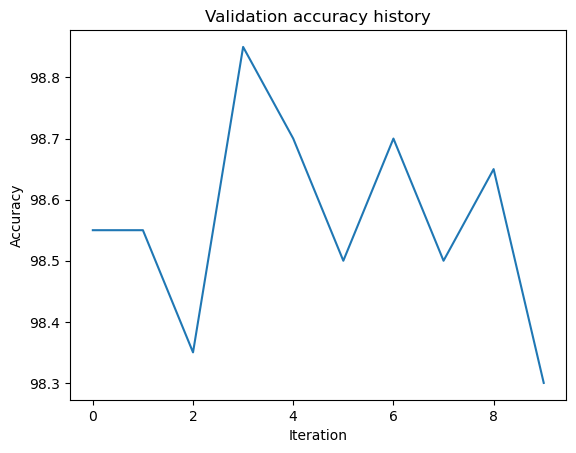

In [55]:
# Plot the training losses
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# Plot the validation accuracy
plt.plot(accuracies)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Validation accuracy history')
plt.show()

In [56]:
# Load the best parameters
new_model.load_state_dict(torch.load('best_triplet_model.pth'))

new_model.eval()

# Calculate the test loss
with torch.no_grad():
    test_correct = 0
    test_total = 0
    for i, (image,_,_,label) in enumerate(triplet_test_loader):
        image = image.to(device)
        label = label.to(device)
        outputs = new_model(image)
        _, predicted = torch.max(outputs.data, 1)
        test_total += label.size(0)
        test_correct += (predicted == label).sum().item()
        del image, label, outputs

    test_accuracy = 100 * test_correct / test_total
    print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), test_accuracy))

Accuracy of the network on the 10000 test images: 97.1 %


In [57]:
# Freeze params
for params in new_model.parameters():
    params.requires_grad = False

# Remove the last layer
new_model.classifier = nn.Sequential(*list(new_model.classifier.children())[:-1])

# Add a new layer
new_model.classifier.add_module('6', nn.Linear(4096, 2))

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [58]:
total_step = len(train_loader)
best_loss = float('inf')  # Initialize the best loss with infinity

losses = []
accuracies = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    losses.append(loss.item())

    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
          .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        accuracy = 100 * correct / total
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, accuracy))
        accuracies.append(accuracy)
        # Save the best parameters based on the lowest validation loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), 'best_triplet-entropy_model.pth')


Epoch [1/20], Step [141/141], Loss: 0.0446
Accuracy of the network on the 5000 validation images: 96.2 %
Epoch [2/20], Step [141/141], Loss: 0.1518
Accuracy of the network on the 5000 validation images: 96.5 %
Epoch [3/20], Step [141/141], Loss: 0.0434
Accuracy of the network on the 5000 validation images: 95.8 %
Epoch [4/20], Step [141/141], Loss: 0.0775
Accuracy of the network on the 5000 validation images: 96.9 %
Epoch [5/20], Step [141/141], Loss: 0.0038
Accuracy of the network on the 5000 validation images: 96.0 %
Epoch [6/20], Step [141/141], Loss: 0.0481
Accuracy of the network on the 5000 validation images: 96.5 %
Epoch [7/20], Step [141/141], Loss: 0.0194
Accuracy of the network on the 5000 validation images: 96.4 %
Epoch [8/20], Step [141/141], Loss: 0.1014
Accuracy of the network on the 5000 validation images: 96.6 %
Epoch [9/20], Step [141/141], Loss: 0.0051
Accuracy of the network on the 5000 validation images: 95.7 %
Epoch [10/20], Step [141/141], Loss: 0.0070
Accuracy of

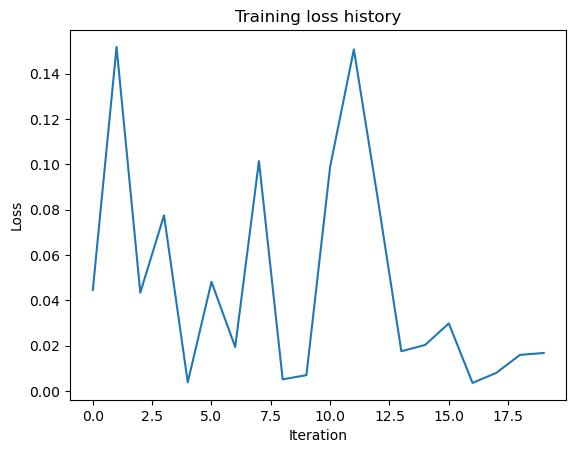

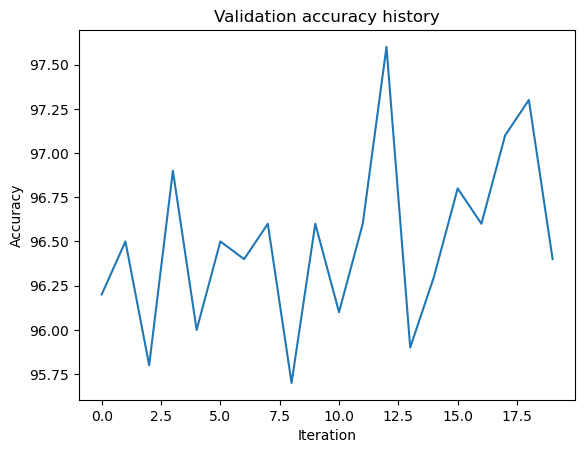

In [59]:
# Plot the training losses
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

# Plot the validation accuracy
plt.plot(accuracies)
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Validation accuracy history')
plt.show()

In [60]:
model.eval()

# Calculate the test loss
with torch.no_grad():
    test_correct = 0
    test_total = 0
    for i, (image,_,_,label) in enumerate(triplet_test_loader):
        image = image.to(device)
        label = label.to(device)
        outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        test_total += label.size(0)
        test_correct += (predicted == label).sum().item()
        del image, label, outputs

    test_accuracy = 100 * test_correct / test_total
    print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), test_accuracy))

Accuracy of the network on the 10000 test images: 95.7 %


In [61]:
# Combine 2 losses 
num_classes = 2
learning_rate = 0.01
class Combined_model(nn.Module):
    def __init__(self, num_classes =2):
        super(Combined_model, self).__init__()
        # Create feature extractor
        self.feature_extractor = AlexNet(num_classes)
        # Remove the last layer
        self.feature_extractor.classifier = nn.Sequential(*list(self.feature_extractor.classifier.children())[:-1])

        # Number of last layer's outputs
        num_ftrs = self.feature_extractor.classifier[4].in_features
        # Create classifier
        self.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 2),
        )

    def forward(self, x):
        features = self.feature_extractor(x)
        predictions = self.classifier(features)

        return features, predictions

model = Combined_model(num_classes)
model = model.to(device)

# Define loss function and optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [64]:
epochs = 10

losses = []
accuracies = []
best_loss = float('inf')  # Initialize the best loss with infinity
for epoch in range(epochs):
    for i, (anchor_img, positive_img, negative_img, anchor_label) in enumerate(triplet_train_loader):
        # Move tensors to the configured device
        anchor_img = anchor_img.to(device)
        positive_img = positive_img.to(device)
        negative_img = negative_img.to(device)
        anchor_label = anchor_label.to(device)
        
        # Forward pass
        anchor_output, label_prediction = model(anchor_img)
        positive_output,_ = model(positive_img)
        negative_output,_ = model(negative_img)
        
        criterion = nn.TripletMarginLoss()

        triplet_loss = criterion(
            anchor_output,
            positive_output,
            negative_output
        )

        criterion = nn.CrossEntropyLoss()
        cross_entropy_loss = criterion(label_prediction, anchor_label)

        loss = cross_entropy_loss + triplet_loss

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    losses.append(loss.item())
        
    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
            .format(epoch+1, epochs, i+1, len(triplet_train_loader), loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (image,_,_,label) in enumerate(triplet_valid_loader):
            image = image.to(device)
            label = label.to(device)
            _, outputs = model(image)
            _, predicted = torch.max(outputs.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            del image, label, outputs

        accuracy = 100 * correct / total
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, accuracy))
        accuracies.append(accuracy)
        # Save the best parameters based on the lowest validation loss
        if loss < best_loss:
            best_loss = loss
            torch.save(model.state_dict(), 'best_triplet&cross_entropy_model.pth')

Epoch [1/10], Step [125/125], Loss: 0.4166
Accuracy of the network on the 5000 validation images: 93.35 %
Epoch [2/10], Step [125/125], Loss: 0.3979
Accuracy of the network on the 5000 validation images: 91.7 %
Epoch [3/10], Step [125/125], Loss: 0.4681
Accuracy of the network on the 5000 validation images: 95.5 %
Epoch [4/10], Step [125/125], Loss: 0.1350
Accuracy of the network on the 5000 validation images: 96.1 %
Epoch [5/10], Step [125/125], Loss: 0.3315
Accuracy of the network on the 5000 validation images: 95.95 %
Epoch [6/10], Step [125/125], Loss: 0.3457
Accuracy of the network on the 5000 validation images: 96.15 %
Epoch [7/10], Step [125/125], Loss: 0.3150
Accuracy of the network on the 5000 validation images: 95.8 %
Epoch [8/10], Step [125/125], Loss: 0.0072
Accuracy of the network on the 5000 validation images: 97.2 %
Epoch [9/10], Step [125/125], Loss: 0.1210
Accuracy of the network on the 5000 validation images: 96.5 %
Epoch [10/10], Step [125/125], Loss: 0.0529
Accuracy

In [65]:
model.eval()

# Calculate the test loss
with torch.no_grad():
    test_correct = 0
    test_total = 0
    for i, (image,_,_,label) in enumerate(triplet_test_loader):
        image = image.to(device)
        label = label.to(device)
        _, outputs = model(image)
        _, predicted = torch.max(outputs.data, 1)
        test_total += label.size(0)
        test_correct += (predicted == label).sum().item()
        del image, label, outputs

    test_accuracy = 100 * test_correct / test_total
    print('Accuracy of the network on the {} test images: {} %'.format(len(test_loader.dataset), test_accuracy))

Accuracy of the network on the 10000 test images: 97.0 %


In [1]:
# Set the model to evaluation mode
model.eval()

# Select a random batch of images and labels from the train loader
batch_images, batch_labels = next(iter(test_loader))

# Move the batch to the device
batch_images = batch_images.to(device)
batch_labels = batch_labels.to(device)

# Get the predicted outputs from the model
with torch.no_grad():
    _ ,outputs = model(batch_images)
    _, predicted_labels = torch.max(outputs, 1)

# Convert the batch images and labels to numpy arrays
batch_images = batch_images.cpu().numpy()
batch_labels = batch_labels.cpu().numpy()
predicted_labels = predicted_labels.cpu().numpy()

# Choose the first 8 images from the batch
batch_images = batch_images[:8]
batch_labels = batch_labels[:8]
predicted_labels = predicted_labels[:8]

# Plot the images and write the titles
fig, axs = plt.subplots(1, len(batch_images), figsize=(15, 6))

for i, (image, true_label, predicted_label) in enumerate(zip(batch_images, batch_labels, predicted_labels)):
    # Unnormalize the image
    image = image / 2 + 0.5
    image = np.clip(image, 0, 1)

    # Set the title color based on the correctness of the prediction
    title_color = 'black'
    if true_label != predicted_label:
        title_color = 'red'

    # Plot the image and write the title
    axs[i].imshow(np.transpose(image, (1, 2, 0)))
    axs[i].set_title(f'True: {classes[true_label]}\nPredicted: {classes[predicted_label]}', color=title_color)
    axs[i].axis('off')
plt.tight_layout()
plt.show()

plt.show()


NameError: name 'model' is not defined